In [1]:

import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Clara
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline 

Data ingestion and cleaning

In [2]:
df= pd.read_csv("project_adult.csv")
df_val = pd.read_csv("project_validation_inputs.csv")

In [3]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
df_val.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


In [5]:
# remove unnamed column - original index column
df = df.drop(columns=["Unnamed: 0"])
df_val = df_val.drop(columns=["Unnamed: 0"])

In [6]:

# Identifying missing values 
cols_with_question_mark = df.columns[df.isin(['?']).any()]
print("Columns with '?' values:")
print(cols_with_question_mark)


Columns with '?' values:
Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [7]:
question_mark_counts = (df == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         1447
occupation        1454
native-country     458
dtype: int64


In [8]:
cols_with_question_mark = df_val.columns[df_val.isin(['?']).any()]
question_mark_counts = (df_val == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         389
occupation        389
native-country    125
dtype: int64


Imputing missing values with the mode and Scaling data

In [9]:

# Replace '?' with NaN
df = df.replace('?', np.nan)

df_val = df_val.replace('?', np.nan)

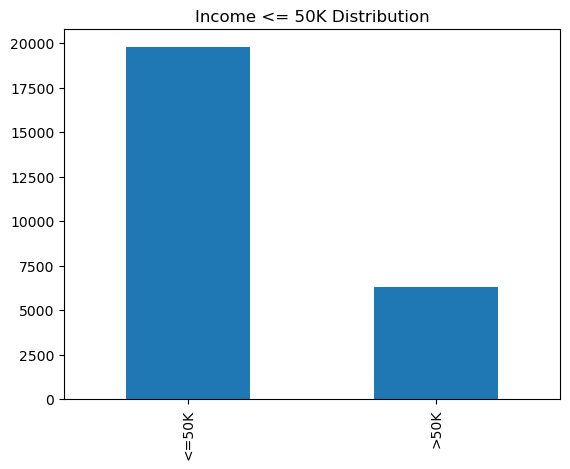

In [10]:
df['income'].value_counts().plot(kind='bar')
plt.title('Income <= 50K Distribution')
plt.show()


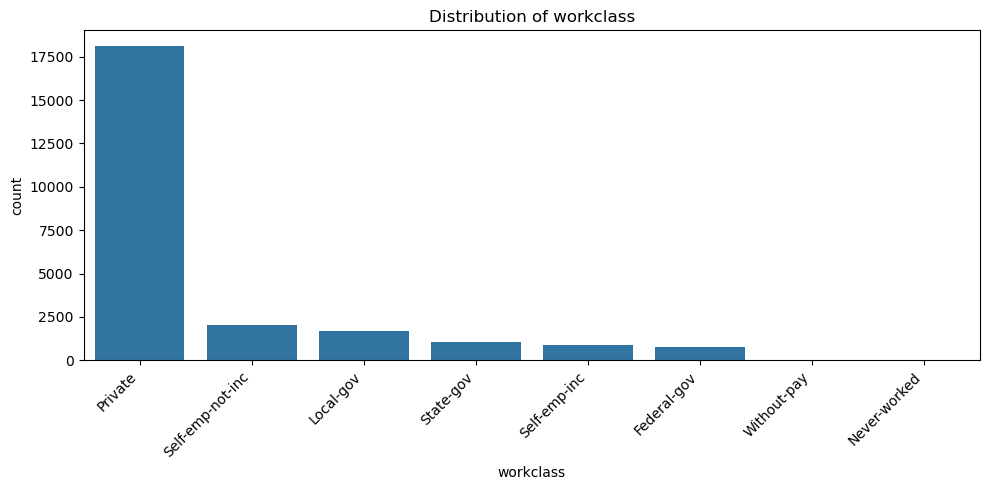

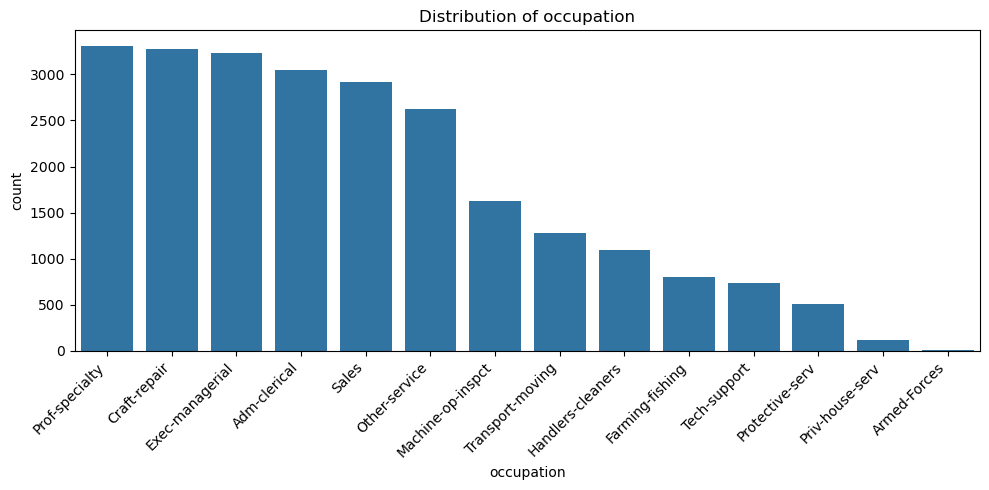

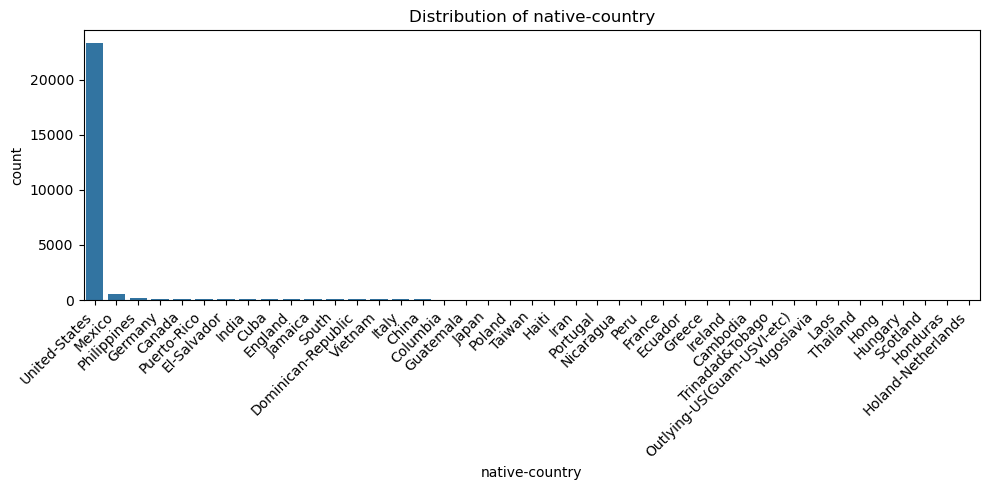

In [11]:


# Ploting distributions for columns with missing values
cols_to_plot = ['workclass', 'occupation', 'native-country']

for col in cols_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [12]:
#Impute missing values in each column with its mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df_val.columns:
    df_val[col] = df_val[col].fillna(df_val[col].mode()[0])

In [13]:
# Encoding and spliting data

TEST_SIZE   = 0.20
RANDOM_SEED = 35

categorical_cols = ['workclass','education','marital-status','occupation',
                    'relationship','race','sex','native-country']
numerical_cols   = ['age','fnlwgt','education-num','capital-gain',
                    'capital-loss','hours-per-week']

# clean column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r'\s+', '-', regex=True))

df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns],
                    drop_first=True)

# split features and target
X = df.drop(columns=['income'])
y = df['income'].map({">50K": 1, "<=50K": 0})

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Scale numeric columns
scaler = StandardScaler()
X_train_df[numerical_cols] = scaler.fit_transform(X_train_df[numerical_cols])
X_test_df[numerical_cols]  = scaler.transform(X_test_df[numerical_cols])

# Convert to NumPy
X_train = X_train_df.to_numpy(dtype=np.float64)
X_test  = X_test_df.to_numpy(dtype=np.float64)
y_train = y_train.to_numpy(dtype=np.int64)
y_test  = y_test.to_numpy(dtype=np.int64)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (20838, 97), X_test: (5210, 97)
y_train: (20838,), y_test: (5210,)


In [14]:
X_test_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
24683,0.909427,1.420352,-0.420869,0.903052,-0.219642,-0.027764,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
19510,-0.631591,0.626491,-0.033139,-0.145398,-0.219642,0.784112,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1533,0.469136,-1.076239,0.354591,-0.145398,-0.219642,-0.027764,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
20074,-0.925119,-1.473670,-0.420869,-0.145398,-0.219642,-0.027764,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
22550,0.322372,1.569855,-0.420869,-0.145398,-0.219642,-0.027764,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Perceptron Model

Hard coded version

In [15]:
#renamed to prevent confusion with sklearn Perceptron
class Perceptron_book:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [16]:
#model training 
ppn = Perceptron_book(eta=.01, n_iter=100, random_state=1)
ppn.fit(X_train, y_train)

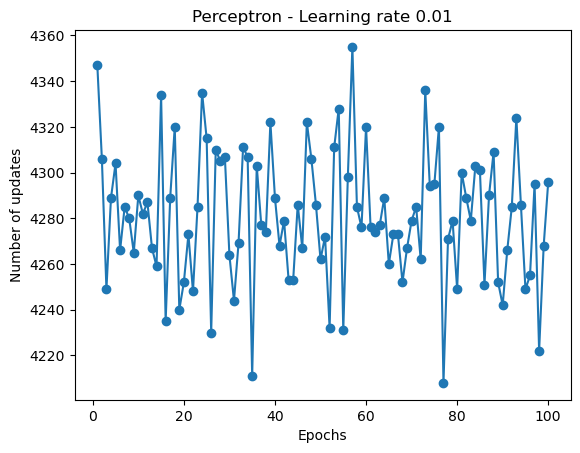

In [17]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.title('Perceptron - Learning rate 0.01')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

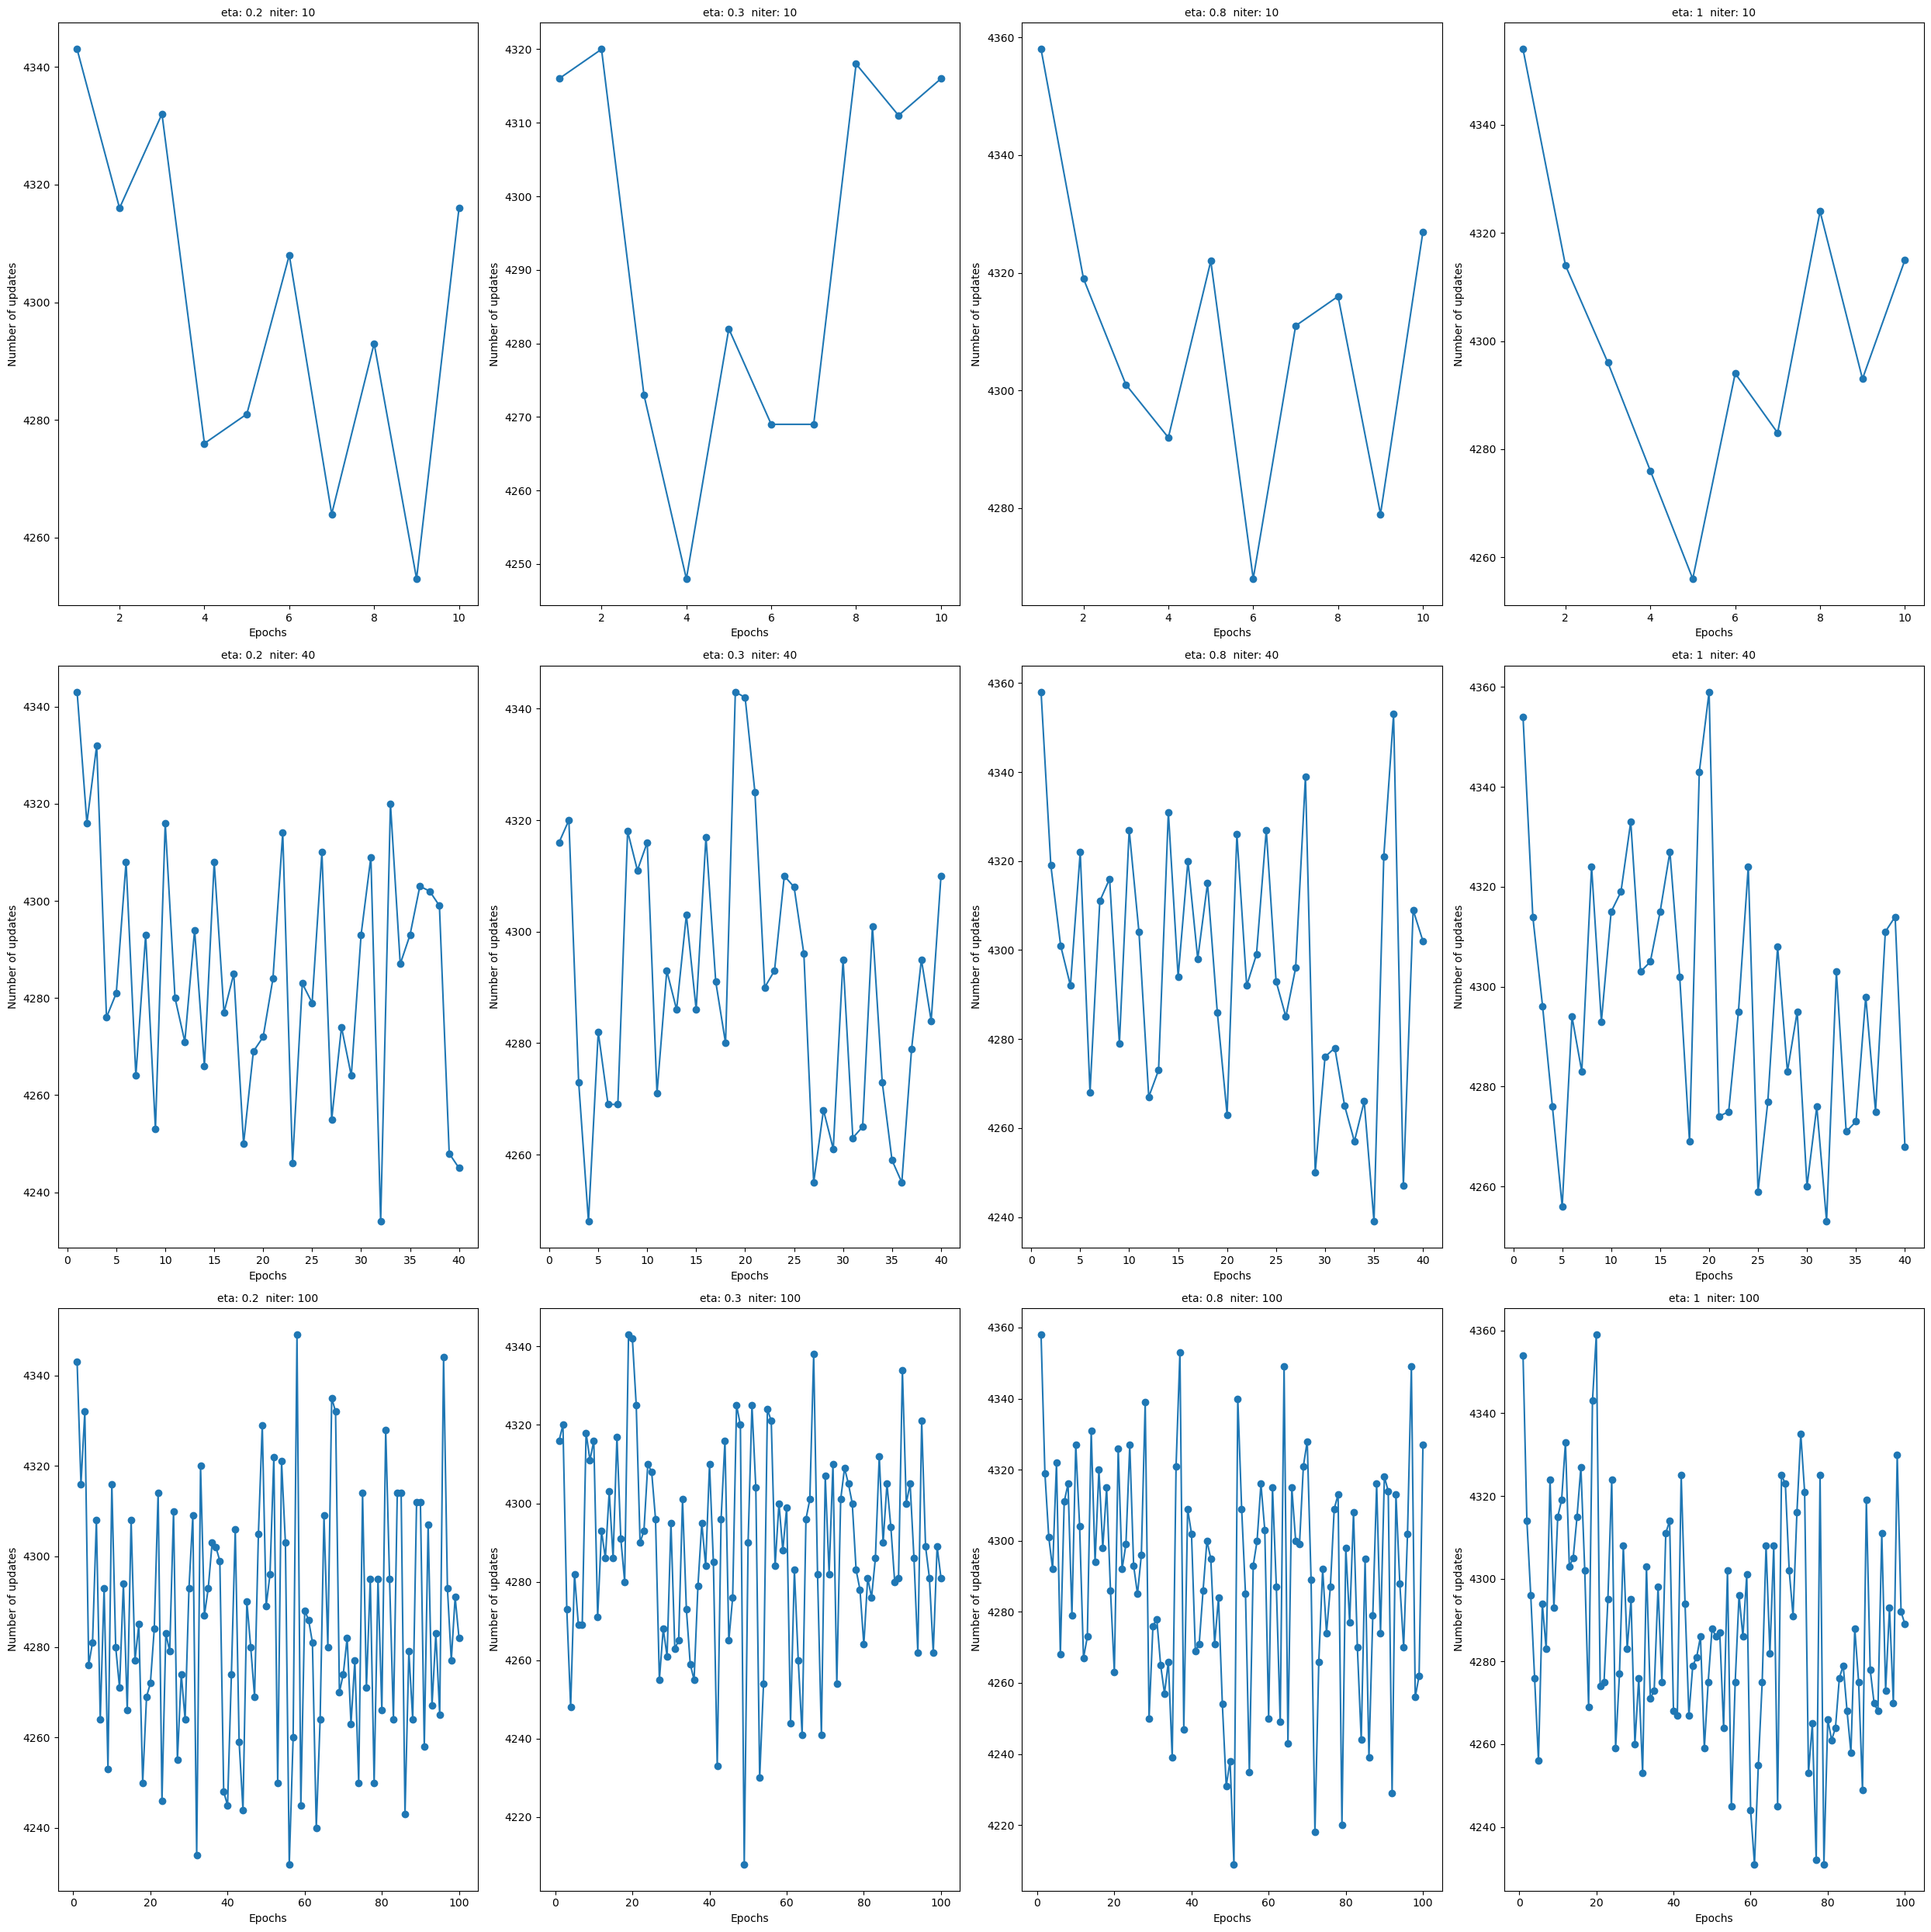

In [18]:
# Train Perceptron and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25, 25))

list_eta = [0.2, 0.3, 0.8, 1]
list_niter = [10, 40, 100]

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron_book(n_iter=n_temp, eta= e_temp).fit(X_train, y_train)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
    
plt.tight_layout()
plt.show()

In [19]:
# prediction accuracy 
train_preds = ppn.predict(X_train)
test_preds  = ppn.predict(X_test)

train_acc = (train_preds == y_train).mean()
test_acc  = (test_preds == y_test).mean()

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")

Train accuracy: 0.787
Test accuracy:  0.791


In [20]:

# Initialize model  
PPN = Perceptron( 
    penalty=None,     
    alpha=0.0001,      
    max_iter=1000,     # number of epochs 
    eta0=1.0,          
    random_state=42,
    tol=1e-3           
)
# Train model
PPN.fit(X_train, y_train)

# Predictions
y_pred = ppn.predict(X_test)

# Evaluation
print("Train accuracy:", accuracy_score(y_train, PPN.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Train accuracy: 0.805163643343891
Test accuracy: 0.791362763915547


In [21]:
#confussion matrix for book model 
y_pred_book = ppn.predict(X_test)
cm_book = confusion_matrix(y_test, y_pred_book, labels=[0, 1])
pd.set_option("display.expand_frame_repr", False)  # keeps it on one line if wide
print("\nBook version Perceptron confusion matrix:")
print(pd.DataFrame(cm_book,
                   index=["true<=50K", "true>50K"],
                   columns=["pred<=50K", "pred>50K"]))

# confussion matrix for sklearn model
y_pred = PPN.predict(X_test)
cm_ppn = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nScikit Learn Perceptron confusion matrix:")
print(pd.DataFrame(cm_ppn,
                   index=["true<=50K", "true>50K"],
                   columns=["pred<=50K", "pred>50K"]))



Book version Perceptron confusion matrix:
           pred<=50K  pred>50K
true<=50K       3554       402
true>50K         685       569

Scikit Learn Perceptron confusion matrix:
           pred<=50K  pred>50K
true<=50K       3445       511
true>50K         527       727


Adaline Model

In [22]:
#In class implementation of Adaline with SGD
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    # # ----Updated version with gradient clipping to handel one hot encoded data----
    # def _update_weights(self, xi, target):
    #   output = self.activation(self.net_input(xi))
    #   error = (target - output)
      
    #   # Gradient computation
    #   grad_w = 2.0 * xi * error
    #   grad_b = 2.0 * error
      
    #   grad_w = np.clip(grad_w, -1, 1)
    #   grad_b = np.clip(grad_b, -1, 1)
      
    #   # Update weights
    #   self.w_ += self.eta * grad_w
    #   self.b_ += self.eta * grad_b
      
    #   return error**2
 
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [23]:
#Train model 
ada = AdalineSGD(eta=.001, n_iter=100, random_state=1)
ada.fit(X_train, y_train)  


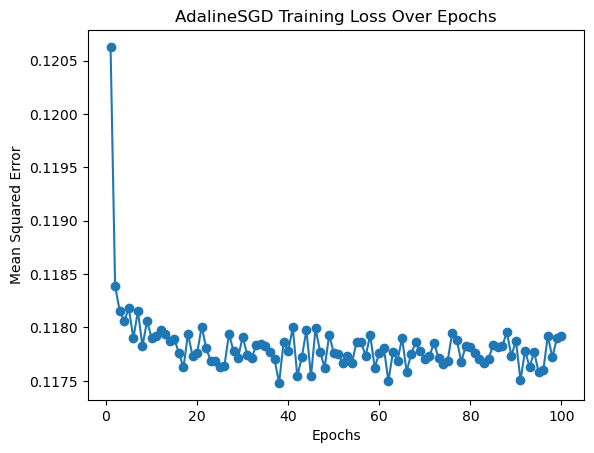

In [24]:
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('AdalineSGD Training Loss Over Epochs')
plt.show()



In [25]:
#  Book version Adaline
y_train_pred_ada = ada.predict(X_train)
y_test_pred_ada  = ada.predict(X_test)

print("\nBook version Adaline:")
print(f"  Train accuracy: {accuracy_score(y_train, y_train_pred_ada):.4f}")
print(f"  Test  accuracy: {accuracy_score(y_test,  y_test_pred_ada):.4f}")



Book version Adaline:
  Train accuracy: 0.8427
  Test  accuracy: 0.8397


In [26]:
# Scikit-learn Adaline (SGDClassifier) 
sk_ada = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant', max_iter=100, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_train_pred_ada = sk_ada.predict(X_train)
sk_y_pred_ada = sk_ada.predict(X_test)

print("\nScikit-learn Adaline (SGDClassifier):")
print(f"  Train accuracy: {accuracy_score(y_train, sk_y_train_pred_ada):.4f}")
print(f"  Test  accuracy: {accuracy_score(y_test,  sk_y_pred_ada):.4f}")


Scikit-learn Adaline (SGDClassifier):
  Train accuracy: 0.8006
  Test  accuracy: 0.8027


In [27]:

#  Book version Adaline confusion matrix
y_pred_ada = ada.predict(X_test)
cm_ada = confusion_matrix(y_test, y_pred_ada, labels=[0, 1])
print("\nBook version Adaline confusion matrix test:")
print(pd.DataFrame(cm_ada,
                   index=["true<=50K", "true>50K"],
                   columns=["pred<=50K", "pred>50K"]))

# Scikit-learn Adaline (SGDClassifier) confusion matrix
cm_sk_ada = confusion_matrix(y_test, sk_y_pred_ada, labels=[0, 1])
print("\nScikit-learn Adaline (SGDClassifier) confusion matrix test:")
print(pd.DataFrame(cm_sk_ada,
                   index=["true<=50K", "true>50K"],
                   columns=["pred<=50K", "pred>50K"]))


Book version Adaline confusion matrix test:
           pred<=50K  pred>50K
true<=50K       3727       229
true>50K         606       648

Scikit-learn Adaline (SGDClassifier) confusion matrix test:
           pred<=50K  pred>50K
true<=50K       3891        65
true>50K         963       291


In [28]:
# Clara
# Implemetation of Scikit-Learn to train a Logistic Regression Model

# The idea of a balanced dataset is very important when evaluating machine learning models.
# Looking at the distribution of outcomes can help us look at the imbalance ratio of the target class, >50k.
# Notice how the numbers correctly correspond with the ratios found in an online data analytics article, which discusses this dataset.
# https://www.analyticsvidhya.com/blog/2022/06/is-adult-income-dataset-imbalanced/
print("Distribution of outcomes for the training set.")
train_counts = np.bincount(y_train) # Count out the class labels
print(train_counts)
print(train_counts / train_counts.sum() * 100)

print("Distribution of outcomes for the testing set.")
test_counts = np.bincount(y_test) # Count out the class labels
print(test_counts)
print(test_counts / test_counts.sum() * 100)

# Compute a ratio of the positive outcomes, versus the negative outcomes.
imbalance_ratio = train_counts.max() / train_counts.min()
print(f"\nImbalance Ratio (Train Set): {imbalance_ratio:.2f}:1")

Distribution of outcomes for the training set.
[15822  5016]
[75.928592 24.071408]
Distribution of outcomes for the testing set.
[3956 1254]
[75.93090211 24.06909789]

Imbalance Ratio (Train Set): 3.15:1


In [29]:
# Unbalanced Logistic Regression
log_reg = LogisticRegression(
    solver="lbfgs", # Default solver; common batch solver for classification      
    max_iter=1000, # Max iterations to ensure convergence
    random_state=RANDOM_SEED # 35
)
# Fit the logistic regression model on the training data, preprocessed by Carlie. 
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Print metrics
print("Unbalanced Logistic Regression (i.e., the default)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")

# Print classification report, including the usual suspects like precision, recall, F1, ect. 
print(classification_report(y_test, y_pred_lr, target_names=["<=50K", ">50K"]))

Unbalanced Logistic Regression (i.e., the default)
Accuracy: 0.8507
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      3956
        >50K       0.73      0.60      0.66      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.76      0.78      5210
weighted avg       0.84      0.85      0.85      5210



In [30]:
# Balanced Logistic Regression
# Very similar to the above, but now we're throwing in a balancing parameter
log_reg_balanced = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    class_weight="balanced"   # This is different! 
)

# Fit and predict
log_reg_balanced.fit(X_train, y_train)
y_pred_lr_balanced = log_reg_balanced.predict(X_test)

# Classification report
print("Balanced Logistic Regression")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_balanced):.4f}")
print(classification_report(y_test, y_pred_lr_balanced, target_names=["<=50K", ">50K"]))


Balanced Logistic Regression
Accuracy: 0.8052
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86      3956
        >50K       0.56      0.85      0.68      1254

    accuracy                           0.81      5210
   macro avg       0.75      0.82      0.77      5210
weighted avg       0.85      0.81      0.82      5210



In [31]:
# Logistic Regression with cross-validation to tune C, the hyperparameter
log_reg_cv = LogisticRegressionCV(
    Cs=10,                  # Evaluate ten different C values
    cv=5,                   # 5-fold CV to evaluate every C
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1 # Just for flavor; use all the available cores to compute efficiently.
)

# Train and fit
log_reg_cv.fit(X_train, y_train)
y_pred_lr_cv = log_reg_cv.predict(X_test)

# Classification report
print("Logistic Regression with Cross-Validation")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_cv):.4f}")
print(classification_report(y_test, y_pred_lr_cv, target_names=["<=50K", ">50K"]))


Logistic Regression with Cross-Validation
Accuracy: 0.8514
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      3956
        >50K       0.74      0.59      0.66      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.76      0.78      5210
weighted avg       0.84      0.85      0.85      5210



In [32]:
# Create storage for all models
results = []
trained_models = {}

In [33]:
# Mega-function to run logistic regression models and store performance metrics.
# I know the way I did it is kinda silly, but having a slam-bang function felt easy.
def run_model(name, model, X_train, y_train, X_test, y_test):
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Generate a classification report. 
    report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"], output_dict=True)
    
    # Remember that above results list? Append the model and its performance metrics so it can be printed later.
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_>50K": report[">50K"]["precision"],
        "Recall_>50K": report[">50K"]["recall"],
        "F1_>50K": report[">50K"]["f1-score"],
        "Best_C": getattr(model, "C_", None) if hasattr(model, "C_") else None
    })
    
    # Store the trained models for later.
    trained_models[name] = model


In [34]:
# Similar, but for SVM models

def run_svm(name, model):
    # So remember: SVMs are very sensitive to feature magnitudes.
    pipe = Pipeline([
        ("scaler", StandardScaler()), # Standardize features using run of the mill means and SD.
        ("svm", model)]) # Well, we're doing an SVM, right? 
    # Fit and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Make classification report
    report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"], output_dict=True)
    
    # Store performance metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_>50K": report[">50K"]["precision"],
        "Recall_>50K": report[">50K"]["recall"],
        "F1_>50K": report[">50K"]["f1-score"],
        "Best_C": getattr(model, "C", None)
    })
    
    # Store the pipeline
    trained_models[name] = pipe


In [35]:
# A series of five different logreg models, shotgunned using run_model.

# LogReg (Unbalanced): plain logistic regression, no class weighting.​
# LogReg (Balanced): logistic regression with class_weight="balanced" to adjust for class imbalance.​
# LogReg (CV tuned): cross-validated logistic regression (10 values of C, 5-fold CV).​
# LogReg (CV tuned, L2): cross-validated logistic regression with L2 regularization, testing C values from 0.001 to 1000, optimized using the F1 score.​
# LogReg (CV tuned, L1): cross-validated with L1 regularization, using the saga solver, scored by F1.

run_model("LogReg (Unbalanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED), X_train, y_train, X_test, y_test)
run_model("LogReg (Balanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, class_weight="balanced"), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned)", LogisticRegressionCV(Cs=10, cv=5, solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned, L2)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l2", solver="lbfgs", max_iter=2000, scoring="f1", random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned, L1)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l1", solver="saga", max_iter=3000, scoring="f1", random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)


In [37]:
# Running in too soon? It's what I did for the logregs, but this time, we've got Support Vectors.

# SVM (Linear, Unbalanced): linear kernel SVM with no class weighting.
# SVM (Linear, Balanced): linear kernel SVM with class_weight="balanced" to adjust for class imbalance.
# SVM (RBF, Unbalanced): RBF (nonlinear) kernel SVM with no class weighting.
# SVM (RBF, Balanced): RBF kernel SVM with class_weight="balanced" to adjust for class imbalance.

# Wait, RBF? Why? 
# Linear kernels draw straight separations between datapoints. 
# Great for simple cases, but RBF allowing curved decision boundaries allows more complex relationships to be captured.
# You'll see how messy the graphs are in a bit. 
run_svm("SVM (Linear, Unbalanced)", SVC(kernel="linear", random_state=RANDOM_SEED))
run_svm("SVM (Linear, Balanced)", SVC(kernel="linear", class_weight="balanced", random_state=RANDOM_SEED))
run_svm("SVM (RBF, Unbalanced)", SVC(kernel="rbf", random_state=RANDOM_SEED))
run_svm("SVM (RBF, Balanced)", SVC(kernel="rbf", class_weight="balanced", random_state=RANDOM_SEED))


In [38]:
# Print the model summaries!
results_df = pd.DataFrame(results).round(4)
print(results_df)

                       Model  Accuracy  Precision_>50K  Recall_>50K  F1_>50K                Best_C
0        LogReg (Unbalanced)    0.8507          0.7329       0.5973   0.6582                  None
1          LogReg (Balanced)    0.8052          0.5634       0.8469   0.6766                  None
2          LogReg (CV tuned)    0.8514          0.7372       0.5949   0.6584  [0.3593813663804626]
3      LogReg (CV tuned, L2)    0.8499          0.7300       0.5973   0.6570                [10.0]
4      LogReg (CV tuned, L1)    0.8501          0.7307       0.5973   0.6573                [10.0]
5   SVM (Linear, Unbalanced)    0.8493          0.7497       0.5614   0.6420                   1.0
6     SVM (Linear, Balanced)    0.7808          0.5279       0.8453   0.6499                   1.0
7      SVM (RBF, Unbalanced)    0.8482          0.7598       0.5399   0.6312                   1.0
8   SVM (Linear, Unbalanced)    0.8493          0.7497       0.5614   0.6420                   1.0
9     SVM 

In [39]:
# Process df_val for the validation step
df_val.columns = (
    df_val.columns
    .str.strip() # Remove space extras
    .str.lower() # Lowercase all columns
    .str.replace(r'\s+', '-', regex=True) # DON'T FEAR REGEX. IT'S JUST BOOFING THE WHITESPACE CHARACTERS WITH DASHES.
)

# Replace the unknowns with mode values from training data (df), if applicable
# For all the columns in the original dataset
for col in df.columns:
    # If the columns are in the validation dataset (superfluous, but eh, can't hurt)
    if col in df_val.columns:
        # MODE IT
        df_val[col] = df_val[col].replace('?', np.nan)
        df_val[col] = df_val[col].fillna(df[col].mode()[0])

# One-hot encode categorical columns like training data
# Basically copied Carlie here.
categorical_cols = [
    'workclass','education','marital-status','occupation',
    'relationship','race','sex','native-country'
]
df_val = pd.get_dummies(df_val, columns=[c for c in categorical_cols if c in df_val.columns], drop_first=True)

# Are there columns missing in the validation set? Make sure the feature space isn't all banged because of the one-hot encoding.
missing_cols = set(X_train_df.columns) - set(df_val.columns)
for col in missing_cols:
    df_val[col] = 0

# Ensure column order matches training set
df_val = df_val[X_train_df.columns]

# Scale with the same scaler fitted on the training data to avoid bias.
df_val[numerical_cols] = scaler.transform(df_val[numerical_cols])

# Convert to NumPy array for prediction
X_val = df_val.to_numpy(dtype=np.float64)


In [ ]:
# Pick the best four models based on F1 score
best_models = results_df.sort_values(by="F1_>50K", ascending=False).head(4)["Model"]

print("Best models for validation:", list(best_models))

# Run validation predictions, predicting above and below 50k
for model_name in best_models:
    model = trained_models[model_name]
    preds = model.predict(X_val) # Where X_val corresponds to df_val's values.
    
    n_total = len(preds) # All the everyone
    n_pos = sum(preds) # Positive targets: over 50k
    n_neg = n_total - n_pos # Negative targets: less than 50k. 
    
    # Print some information in the output so we know we aren't insane.
    print(f"\n{model_name}")
    print(f"Total samples: {n_total}")
    print(f"Predicted >50K (1): {n_pos} ({n_pos/n_total:.2%})")
    print(f"Predicted <=50K (0): {n_neg} ({n_neg/n_total:.2%})")
    print(f"Sample predictions: {preds[:20]}")
    
    # Save only predictions to CSV, for the validation Dr. Specking requires. 
    df_predictions = pd.DataFrame({"prediction": preds})
    csv_filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_validation_predictions.csv"
    df_predictions.to_csv(csv_filename, index=False)
    print(f"Saved predictions for {model_name} to {csv_filename}")


Best models for validation: ['LogReg (Balanced)', 'SVM (RBF, Balanced)', 'LogReg (CV tuned)', 'LogReg (Unbalanced)']

LogReg (Balanced)
Total samples: 6513
Predicted >50K (1): 2353 (36.13%)
Predicted <=50K (0): 4160 (63.87%)
Sample predictions: [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0]
Saved predictions for LogReg (Balanced) to LogReg_Balanced_validation_predictions.csv

SVM (RBF, Balanced)
Total samples: 6513
Predicted >50K (1): 2327 (35.73%)
Predicted <=50K (0): 4186 (64.27%)
Sample predictions: [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0]
Saved predictions for SVM (RBF, Balanced) to SVM_RBF,_Balanced_validation_predictions.csv

LogReg (CV tuned)
Total samples: 6513
Predicted >50K (1): 1307 (20.07%)
Predicted <=50K (0): 5206 (79.93%)
Sample predictions: [0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]
Saved predictions for LogReg (CV tuned) to LogReg_CV_tuned_validation_predictions.csv

LogReg (Unbalanced)
Total samples: 6513
Predicted >50K (1): 1311 (20.13%)
Predicted <=50K (0): 5202 (79.87%)

In [44]:
# Decision boundaries viz
# Select two features, age and hours-per-week
X_two_train = X_train_df[["age", "hours-per-week"]].values
y_two_train = y_train

# Fit a baby Balanced Logistic Regression on the above
Decision_Boundary_Logreg = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=1
)
Decision_Boundary_Logreg.fit(X_two_train, y_two_train)


# Fit a baby SVM on those two
Decision_Boundary_SVM = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=1)
Decision_Boundary_SVM.fit(X_two_train, y_two_train)

SVC(random_state=1)

In [46]:
# Import over the book's implementation of plotting decision boundaries
# Not my code! Page 57 in Chapter 3
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')        

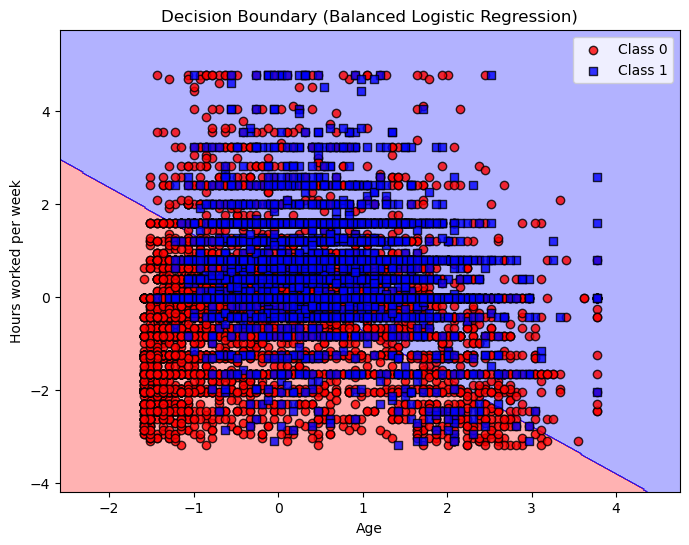

In [ ]:
# Plot decision boundaries for the Logistic Regression
# Warning: Gore
plt.figure(figsize=(8,6))
plot_decision_regions(X_two_train, y_two_train, classifier=Decision_Boundary_Logreg)
plt.xlabel("Age")
plt.ylabel("Hours worked per week")
plt.legend(loc="upper right")
plt.title("Decision Boundary (Balanced Logistic Regression)")
plt.show()


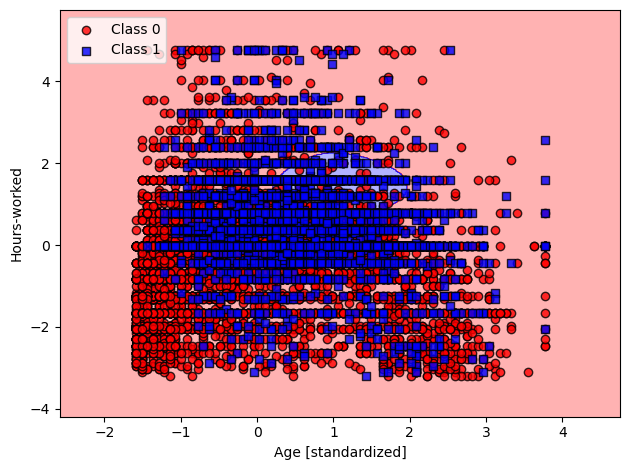

In [ ]:
# Plot decision boundaries for age vs Hours-worked for the SVM
# Warning: Gore, but it's justified
plot_decision_regions(X_two_train, y_two_train, classifier=Decision_Boundary_SVM)

plt.xlabel("Age [standardized]")
plt.ylabel("Hours-worked")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [280]:
# Discussion question f: Vary the C values of the scikit-learn LogisticRegression and linear SVC models with [0.01, 1.0, 100.0]. Discuss the impact.
# Set up C values, and lists to hold results
C_values = [0.01, 1.0, 100.0]
logreg_scores, svc_scores = [], []

for C in C_values:
    logreg_scores.append(f1_score(y_test, make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=1000, random_state=RANDOM_SEED)).fit(X_train, y_train).predict(X_test)))
    svc_scores.append(f1_score(y_test, make_pipeline(StandardScaler(), LinearSVC(C=C, max_iter=5000, tol=1e-2, random_state=RANDOM_SEED)).fit(X_train, y_train).predict(X_test)))

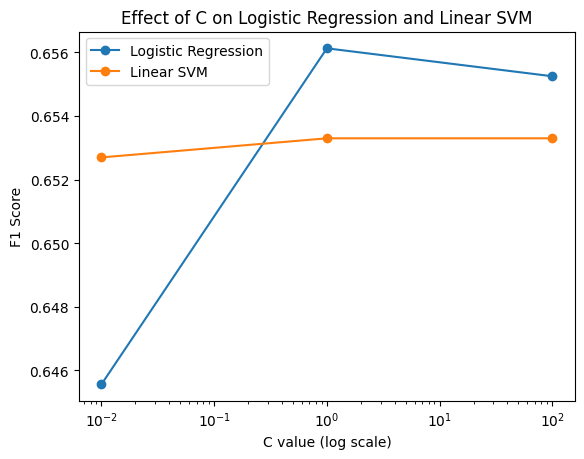

In [281]:
# Viz it
plt.plot(C_values, logreg_scores, marker="o", label="Logistic Regression")
plt.plot(C_values, svc_scores, marker="o", label="Linear SVM")
plt.xscale("log")
plt.xlabel("C value (log scale)")
plt.ylabel("F1 Score")
plt.title("Effect of C on Logistic Regression and Linear SVM")
plt.legend()
plt.show()
